In [1]:
#import packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


## Creating x-time-series data of Lorenz equation

In [2]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 100.0, 0.01)

states = odeint(f, state0, t)


x = states[:,0]




In [3]:
split_time_1 = 7000
# split_time_2 = 8000

time_train = t[:split_time_1]
x_train = x[:split_time_1]

# time_valid = t[split_time_1:split_time_2]
# x_valid = x[split_time_1:split_time_2]

time_test = t[split_time_1:]
x_test = x[split_time_1:]


## Time Series Data

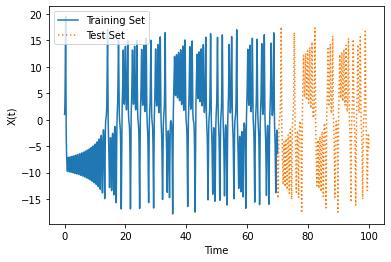

In [4]:
plt.plot(time_train,x_train,'',label = 'Training Set')
#plt.plot(time_valid,x_valid,'--',label = 'Validation Set')
plt.plot(time_test,x_test,':',label = 'Test Set')

plt.legend()
plt.xlabel('Time')
plt.ylabel('X(t)')
#plt.savefig('lorenz.pdf')
plt.show()

## Fitting into a Neural Network Model. Splitting the data into training and test set

In [5]:
#window-size is the input size of the deep learning model
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Neural network Model (2 hidden layer)

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

In [8]:
forecast = []
for time in range(len(x) - window_size):
    forecast.append(model.predict(x[time:time + window_size][np.newaxis]))

forecast1 = forecast[split_time_1-window_size:]
results = np.array(forecast1)[:, 0, 0]

## Prediction

Text(0, 0.5, '$X(t)$')

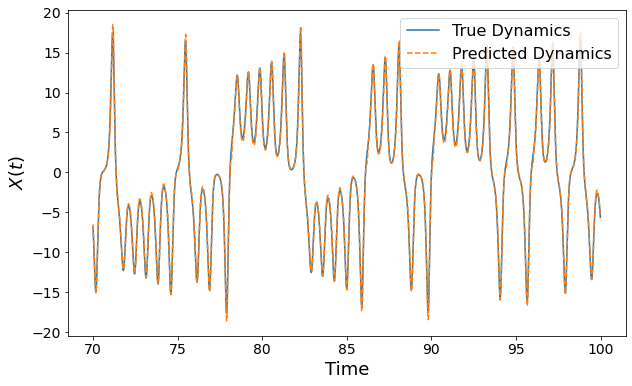

In [9]:
plt.figure(figsize=(10, 6))
#plt.plot(time_valid, x_valid)
plt.plot(time_test,x_test,label = 'True Dynamics')
plt.plot(time_test, results,'--',label = 'Predicted Dynamics')
#plt.plot(time_valid, results1,'--',label = 'Test Set')
plt.legend(loc  = 'upper right',prop={'size': 16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'Time',fontsize = 18)
plt.ylabel(r'$X(t)$',fontsize = 18)
#plt.savefig('lorenz-predict.pdf')

## Mean Square Error

In [11]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(x_test,results, sample_weight=None)
m.result().numpy()


#tf.keras.metrics.root_mean_squared_error(x_test, results).numpy()

0.38073063

## Making a random time-series data. The motivation for the time-series data it is more significant for practical purposes. Generally the stock-market data or experimental data are stochastic in nature.

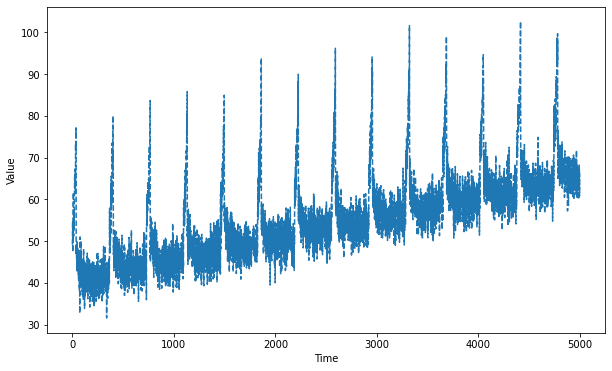

In [12]:
def plot_series(time, series, format="--", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(np.sin(season_time * 6 * np.pi))+ np.sinh(season_time * 6 * np.pi),
                    2 /np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(5000, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 40
amplitude = 10
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

#window-size is the input size of the deep learning model
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time, series)

plt.savefig('series-2.pdf')

## Making the Window Dataset

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Running the model

In [14]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(64, activation="relu"), 
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

## Prediction

In [15]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results1 = np.array(forecast)[:, 0, 0]


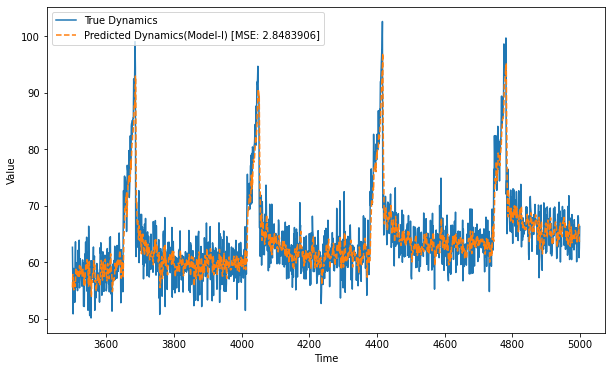

In [16]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format,label = 'True Dynamics')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(False)

    
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

def plot_series(time, series, format="--", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format,label = 'Predicted Dynamics(Model-I) [MSE: 2.8483906]')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(False)
    plt.show()
    


plot_series(time_valid, results1)


# def plot_series(time, series, format="-", start=0, end=None):
#     plt.plot(time[start:end], series[start:end], format,label = 'True Dynamics')
#     plt.xlabel("Time")
#     plt.ylabel("Value")
#     plt.legend()
#     plt.grid(False)

    
# plt.figure(figsize=(10, 6))
# plot_series(time_valid, x_valid)

# def plot_series(time, series, format="--", start=0, end=None):
#     plt.plot(time[start:end], series[start:end], format,label = 'Predicted Dynamics(Model-II)[MSE: 2.8370678]')
#     plt.xlabel("Time")
#     plt.ylabel("Value")
#     plt.legend()
#     plt.grid(False)
#     plt.show()


# plot_series(time_valid, results1)


# def plot_series(time, series, format="-", start=0, end=None):
#     plt.plot(time[start:end], series[start:end], format,label = 'True Dynamics')
#     plt.xlabel("Time")
#     plt.ylabel("Value")
#     plt.legend()
#     plt.grid(False)

    
# plt.figure(figsize=(10, 6))
# plot_series(time_valid, x_valid)

# def plot_series(time, series, format="--", start=0, end=None):
#     plt.plot(time[start:end], series[start:end], format,label = 'Predicted Dynamics(Model-III)[MSE: 3.1574779]')
#     plt.xlabel("Time")
#     plt.ylabel("Value")
#     plt.legend()
#     plt.grid(False)
#     plt.show()


# plot_series(time_valid, results2)




#plt.savefig('mII.pdf')

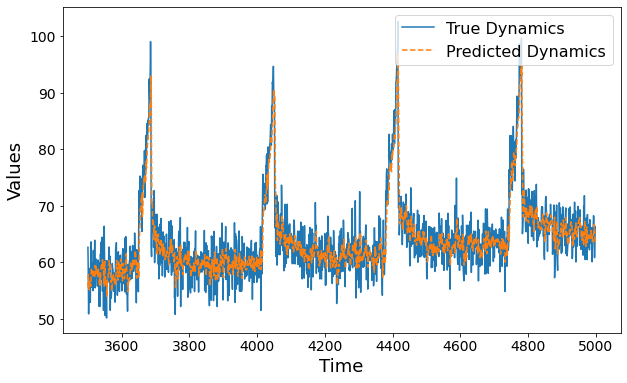

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid,label = 'True Dynamics' )
plt.plot(time_valid, results1,'--',label = 'Predicted Dynamics')

plt.legend(loc  = 'upper right',prop={'size': 16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'Time',fontsize = 18)
plt.ylabel(r'Values',fontsize = 18)
#plt.savefig('mII.pdf')
plt.show()




## Mean Square Error

In [18]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(x_valid,results1, sample_weight=None)
m.result().numpy()


# tf.keras.metrics.root_mean_squared_error(x_valid, results2).numpy()

3.8839183

In [ ]:
100-10-1
128 -64-64-1
128-128-1



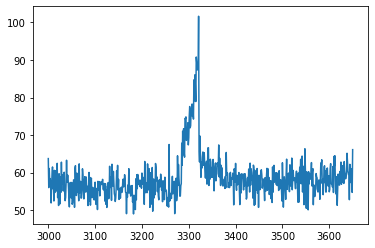

In [86]:
plt.plot(time_valid,x_valid)


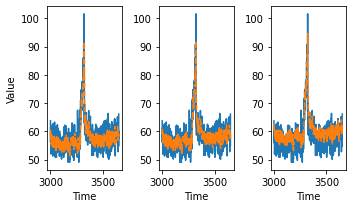

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 3))
axes[0].plot(time_valid, x_valid,label = 'True Dynamics')
axes[0].plot(time_valid, results,'--',label = 'Predicted Dynamics')
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
#axes[0].legend()

axes[1].plot(time_valid, x_valid,label = 'True Dynamics')
axes[1].plot(time_valid, results1,'--',label = 'Predicted Dynamics')
axes[1].set_xlabel("Time")
#axes[0].set_ylabel("Value")
#axes[1].legend()


axes[2].plot(time_valid, x_valid,label = 'True Dynamics')
axes[2].plot(time_valid, results2,'--',label = 'Predicted Dynamics')
axes[2].set_xlabel("Time")
#axes[0].set_ylabel("Value")
#axes[2].legend()

fig.tight_layout()

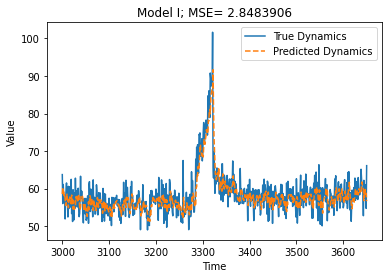

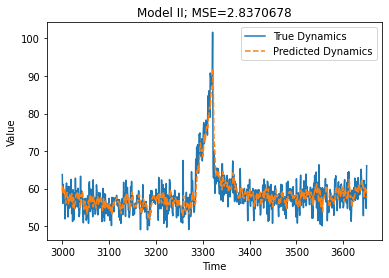

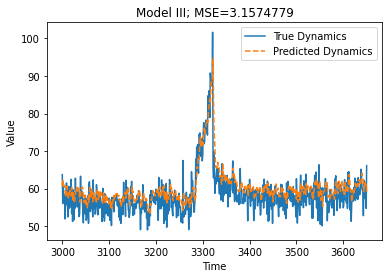

In [104]:
plt.plot(time_valid, x_valid,label = 'True Dynamics')
plt.plot(time_valid, results,'--',label = 'Predicted Dynamics')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title('Model I; MSE= 2.8483906')
plt.savefig('mI.pdf',bbox_inches='tight')
plt.show()

plt.plot(time_valid, x_valid,label = 'True Dynamics')
plt.plot(time_valid, results1,'--',label = 'Predicted Dynamics')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('Model II; MSE=2.8370678')
plt.legend()
plt.savefig('mII.pdf',bbox_inches='tight')
plt.show()


plt.plot(time_valid, x_valid,label = 'True Dynamics')
plt.plot(time_valid, results2,'--',label = 'Predicted Dynamics')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('Model III; MSE=3.1574779')
plt.legend()
plt.savefig('mIII.pdf',bbox_inches='tight')
plt.show()

fig.tight_layout()

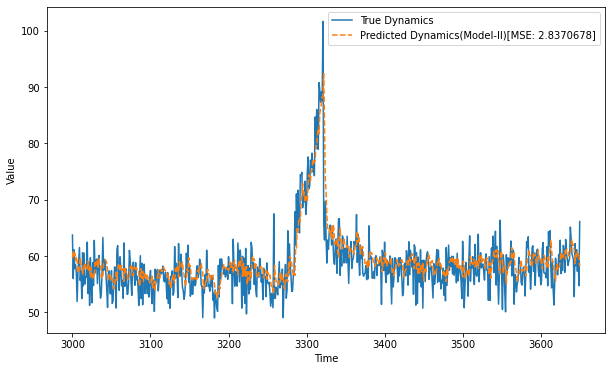

In [123]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format,label = 'True Dynamics')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(False)

    
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

def plot_series(time, series, format="--", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format,label = 'Predicted Dynamics(Model-II)[MSE: 2.8370678]')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(False)
    plt.savefig('mII.pdf',bbox_inches='tight')
    plt.show()


plot_series(time_valid, results1)